In [2]:
%run necessary_functions.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
sns.set_style('darkgrid')

In this project I will simulate stock paths with non-constant volatility which follows the Heston model, inside the function `stock_path_custom_sigma`. Then I shall simulate a delta hedging strategy with different number of control variates and compare the simulated mean of profits with the theoretical Black Scholes call value and Heston call value

(5, 253)


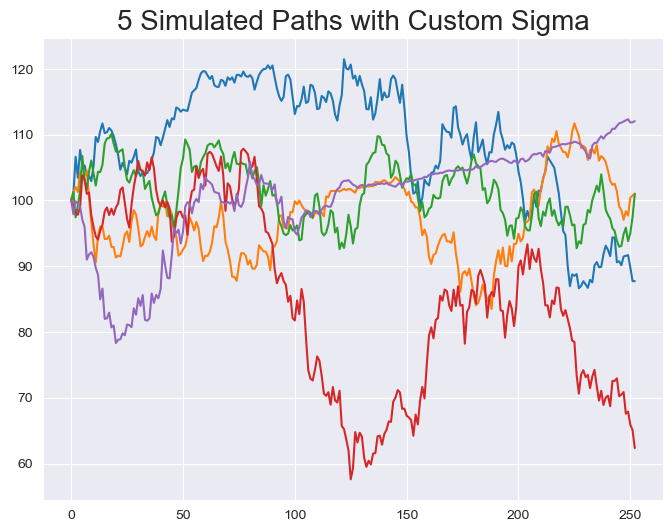

In [4]:

def stock_path_custom_sigma(S0, t, r, mu, phi, v0, rho, n_sims, n_steps):

    dt = t/n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + phi*(0.02 - vols[:, i]) * dt +
                                0.5*np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])

    return paths

S0 = 100
t = 1
r = 0.039
mu = 0.1
rho = -0.8
n_paths = 5
n_steps = 252
phi = 1
v0 = 0.1

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, v0, rho, n_paths, n_steps)

print(simulated_paths.shape)

plt.figure(figsize = (8,6))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)

plt.show()

The above plot shows an example of 5 simulated stock paths under the Heston model. For the following experiments, I am going to assume the following,
- Current price of the asset ($S(0)$): $35
- Time to expiration ($t$): 1 year
- Drift ($\mu$): 0.35
- Correlation between the noise of the volatility model and the stock model ($\rho$): -0.8
- Strike price ($K$): $35
- Initial volatility ($v_0$): $0.25$
- Volatility of volatility (prespecified inside the function): 0.5
- Mean reversion rate ($\phi$): 1
- Long run variance level (presepcified in the function): 0.02

Now we shall simulate 1000 stock paths for variable number of hedges, and fit a heston model to estimate the parameters. Using the estimated values, we shall obtain the call value from the Heston model, and the Black Scholes model. Then we'll compare them to the mean call value new set of 1000 simu


In [ ]:
#Simulate call payouts discounted to time 0
S0 = 35
t = 1
r = 0.039
mu = .35
rho = -0.8
n_sims = 1000
n_steps = 4 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.5**2
K = 35
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

def objective(params, r):
    kappa, theta, xi, rho, v0 = params
    error = 0
    for stock_price in simulated_paths[:,-1]:
        model_price = heston_call(
        S0=100,
        K=110,
        v0=v0,
        r=0.039,
        t=1,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho)
        
        error += (model_price - stock_price) ** 2

    return error

initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 
result = minimize(
    objective,
    initial_guess,
    args=(r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])

C:\Users\sayak\OneDrive\Desktop\AB_research\Erdos Bootcamp\quant_finance_project\necessary_functions.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
C:\Users\sayak\OneDrive\Desktop\AB_research\Erdos Bootcamp\quant_finance_project\necessary_functions.py:881: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]


In [8]:
calibrated_params
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])

Simulated-Black Scholes Price: $13.17  with 1000 simulations 
and 4 control variants and standard error: 0.629609
------------------------------------------------------------------------------------------------------
Maximum profit: $219.90 
Minimum profit: $-79.64795389587161
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $7.47


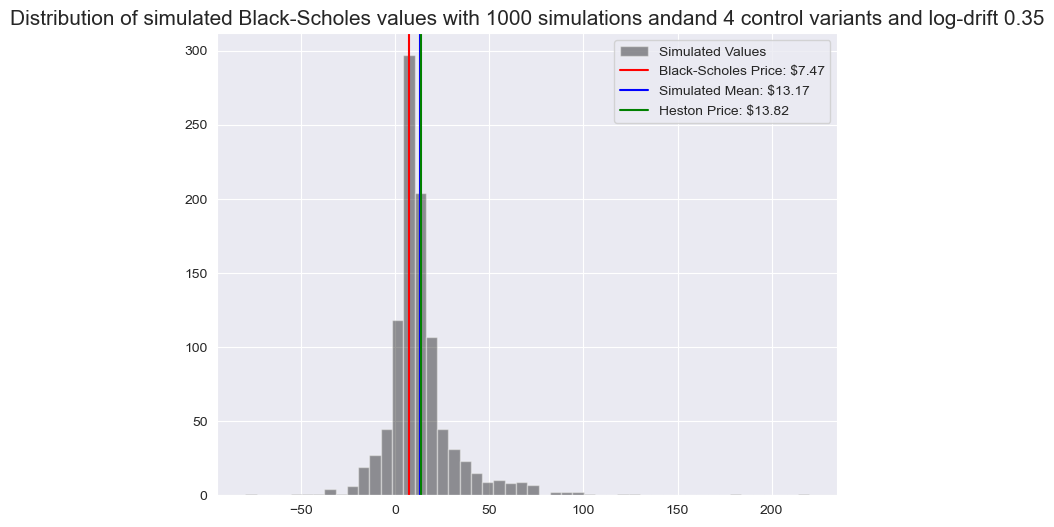

In [ ]:
# #Simulate call payouts discounted to time 0
# S0 = 100
# t = 1
# r = 0.039
# mu = .1
# rho = -0.8
# n_sims = 1000
# n_steps = 4 # number of contorl variates
# n_hedges = n_steps
# phi = 1
# v0 = 0.4**2
# K = 110
# simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

#Simulate call payouts discounted to time 0
S0 = 35
t = 1
r = 0.039
mu = .35
rho = -0.8
n_sims = 1000
n_steps = 4 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.5**2
K = 35
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)


sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]
call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)
dt = t/n_steps

delta_start = bs_call_delta(S0,K,sigma,t,r)
paths_first_steps = simulated_paths[:,0]
first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
stock_profits = []
stock_profits.append(first_stock_profits)

## stock profits in intermediate steps
for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)
profits_hedged = call_payouts - total_stock_profit
std_err = np.std(profits_hedged)/np.sqrt(n_sims)
bs_price = bs_call(S0,K,sigma,t,r)
hs_call = heston_call(S0 = S0, K = K, v0 = v0_opt, r = r, t = t, 
                      kappa = kappa_opt, theta = theta_opt, xi = xi_opt, rho = rho_opt)

#Comparison of simulated value with Black-Scholes
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations \nand \
{n_hedges} control variants and standard error: {std_err:.6f}')
print('------'*17)
print(f'Maximum profit: ${np.max(profits_hedged):.2f} \nMinimum profit: ${np.min(profits_hedged)}')
print('------'*17)
print(f'Black Scholes Price of Call Option: ${bs_price:.2f}')

# Distribution of profits with delta hedging
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(hs_call, label = f'Heston Price: ${hs_call:.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
plt.show()

In [14]:
#Simulate call payouts discounted to time 0
S0 = 35
t = 1
r = 0.039
mu = .35
rho = -0.8
n_sims = 1000
n_steps = 12 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.5**2
K = 35
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

def objective(params, r):
    kappa, theta, xi, rho, v0 = params
    error = 0
    for stock_price in simulated_paths[:,-1]:
        model_price = heston_call(
        S0=100,
        K=110,
        v0=v0,
        r=0.039,
        t=1,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho)
        
        error += (model_price - stock_price) ** 2

    return error

initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 
result = minimize(
    objective,
    initial_guess,
    args=(r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])

C:\Users\sayak\OneDrive\Desktop\AB_research\Erdos Bootcamp\quant_finance_project\necessary_functions.py:881: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]


C:\Users\sayak\OneDrive\Desktop\AB_research\Erdos Bootcamp\quant_finance_project\necessary_functions.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]


Simulated-Black Scholes Price: $11.73  with 1000 simulations 
and 12 control variants and standard error: 0.409124
------------------------------------------------------------------------------------------------------
Maximum profit: $136.54 
Minimum profit: $-60.85865175537651
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $7.47


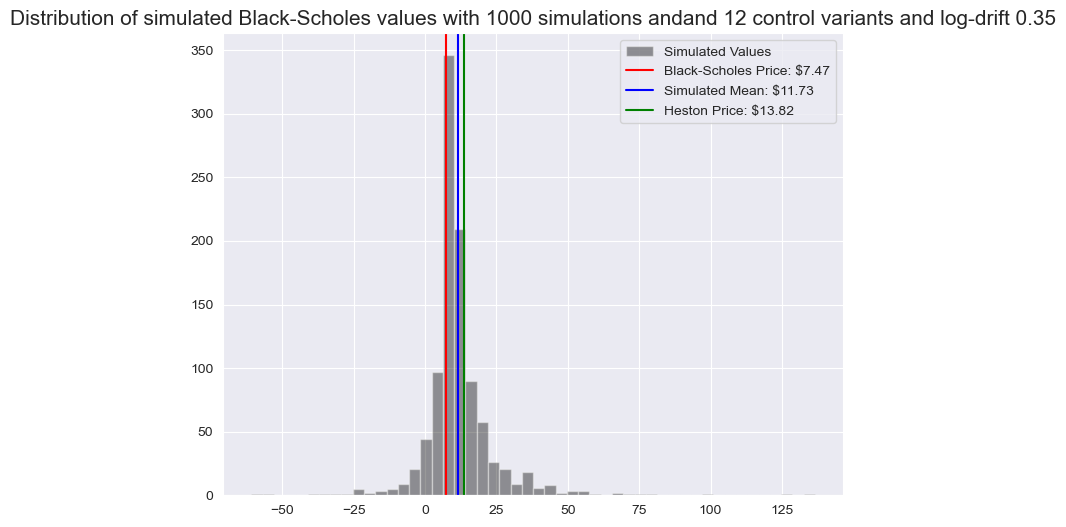

In [18]:
# #Simulate call payouts discounted to time 0
# S0 = 100
# t = 1
# r = 0.039
# mu = .1
# rho = -0.8
# n_sims = 1000
# n_steps = 12 # number of contorl variates
# n_hedges = n_steps
# phi = 1
# v0 = 0.4**2
# K = 110

#Simulate call payouts discounted to time 0
S0 = 35
t = 1
r = 0.039
mu = .35
rho = -0.8
n_sims = 1000
n_steps = 12 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.5**2
K = 35
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)



sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]
call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)
dt = t/n_steps

delta_start = bs_call_delta(S0,K,sigma,t,r)
paths_first_steps = simulated_paths[:,0]
first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
stock_profits = []
stock_profits.append(first_stock_profits)

## stock profits in intermediate steps
for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)
profits_hedged = call_payouts - total_stock_profit
std_err = np.std(profits_hedged)/np.sqrt(n_sims)
bs_price = bs_call(S0,K,sigma,t,r)
hs_call = heston_call(S0 = S0, K = K, v0 = v0_opt, r = r, t = t, 
                      kappa = kappa_opt, theta = theta_opt, xi = xi_opt, rho = rho_opt)

#Comparison of simulated value with Black-Scholes
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations \nand \
{n_hedges} control variants and standard error: {std_err:.6f}')
print('------'*17)
print(f'Maximum profit: ${np.max(profits_hedged):.2f} \nMinimum profit: ${np.min(profits_hedged)}')
print('------'*17)
print(f'Black Scholes Price of Call Option: ${bs_price:.2f}')

# Distribution of profits with delta hedging
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(hs_call, label = f'Heston Price: ${hs_call:.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
plt.show()

In [19]:
#Simulate call payouts discounted to time 0
S0 = 35
t = 1
r = 0.039
mu = .35
rho = -0.8
n_sims = 1000
n_steps = 252 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.5**2
K = 35
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

def objective(params, r):
    kappa, theta, xi, rho, v0 = params
    error = 0
    for stock_price in simulated_paths[:,-1]:
        model_price = heston_call(
        S0=100,
        K=110,
        v0=v0,
        r=0.039,
        t=1,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho)
        
        error += (model_price - stock_price) ** 2

    return error

initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 
result = minimize(
    objective,
    initial_guess,
    args=(r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])

C:\Users\sayak\OneDrive\Desktop\AB_research\Erdos Bootcamp\quant_finance_project\necessary_functions.py:881: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]


Simulated-Black Scholes Price: $10.38  with 1000 simulations 
and 252 control variants and standard error: 0.100472
------------------------------------------------------------------------------------------------------
Maximum profit: $49.37 
Minimum profit: $-3.933289322247674
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $7.47


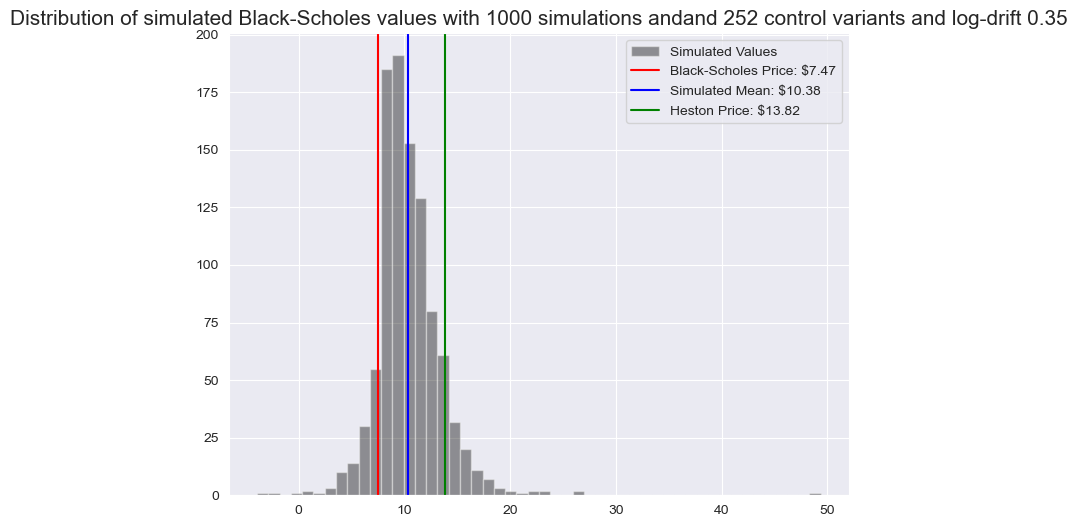

In [35]:
#Simulate call payouts discounted to time 0
S0 = 35
t = 1
r = 0.039
mu = .35
rho = -0.8
n_sims = 1000
n_steps = 252 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.5**2
K = 35
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]
call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)
dt = t/n_steps

delta_start = bs_call_delta(S0,K,sigma,t,r)
paths_first_steps = simulated_paths[:,0]
first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
stock_profits = []
stock_profits.append(first_stock_profits)

## stock profits in intermediate steps
for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)
profits_hedged = call_payouts - total_stock_profit
std_err = np.std(profits_hedged)/np.sqrt(n_sims)
bs_price = bs_call(S0,K,sigma,t,r)
hs_call = heston_call(S0 = S0, K = K, v0 = v0_opt, r = r, t = t, 
                      kappa = kappa_opt, theta = theta_opt, xi = xi_opt, rho = rho_opt)

#Comparison of simulated value with Black-Scholes
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations \nand \
{n_hedges} control variants and standard error: {std_err:.6f}')
print('------'*17)
print(f'Maximum profit: ${np.max(profits_hedged):.2f} \nMinimum profit: ${np.min(profits_hedged)}')
print('------'*17)
print(f'Black Scholes Price of Call Option: ${bs_price:.2f}')

# Distribution of profits with delta hedging
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(hs_call, label = f'Heston Price: ${hs_call:.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
plt.show()

In all the cases, we can see that as the number of hedges went up from quarterly to monthly to daily the standard error for the profits decreased and the range of maximum and minimum profits alswo went down indicating a more stable return. 

Due to having non-constant volatility, in all the above cases we can see that the theoretical value of Black Scholes return is significantly different than the average profit obtain from the simulations. The simulation average apprears to be closer to the Heston call value.

However, we can see that as the number of hedges went up, the simulation average also gradually shifted away from the Heston call value. This could be due to the fact that in the hedging, we are using deltas from the Black scholes model and this causes a sgnificant deviation as the hedging frequency went up.